Load the dataset and define some labels for groups of different columns

In [2]:
import pandas as pd
import os

path = os.path.join('..','results','dataset_with_noNA.csv')
wide_standardized_noNA = pd.read_csv(path)
wide_standardized_noNA['Date'] = pd.to_datetime(wide_standardized_noNA['Date'])

variables = wide_standardized_noNA.columns.tolist()
trN_variables = [var for var in variables if var.startswith('TR') and var.endswith('N')]
pot_variables = [var for var in variables if 'Pot_att' in var]
cosfi = [var for var in variables if var.endswith('cosFi')]

wide_standardized_noNA

,Date,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,2022-01-06 21:00:00,0.325737,-2.141435,-1.511963,0.257900,-2.441477,-2.385681,-2.486445,2.486754,2.639974,2.497832
1,2022-01-06 22:00:00,-0.055789,-0.447794,-0.837576,0.085235,-2.441477,-2.385681,-2.486445,2.402577,2.513033,2.462639
2,2022-01-06 23:00:00,0.230586,-1.294615,-1.039892,0.310450,-2.441477,-2.385681,-2.486445,2.276312,2.534747,2.501964
3,2022-01-07 00:00:00,0.073282,-0.730068,-1.606377,0.248516,-2.441477,-2.385681,-2.486445,2.297356,2.568152,2.494586
4,2022-01-07 01:00:00,0.261105,-1.953253,-1.417549,0.216610,-2.441477,-2.385681,-2.486445,2.465709,2.586525,2.486839
...,...,...,...,...,...,...,...,...,...,...,...
13111,2023-07-07 06:00:00,0.107956,1.716303,-0.837576,0.042069,0.600657,0.935135,0.453502,-0.396297,-0.399918,-0.400139
13112,2023-07-07 07:00:00,0.087578,1.528121,-0.628516,0.152799,0.600657,0.894755,0.435150,-0.396297,-0.399918,-0.400139
13113,2023-07-07 08:00:00,0.111889,1.528121,0.005408,0.141539,0.546333,0.828533,0.448840,-0.396297,-0.399918,-0.400139
13114,2023-07-07 09:00:00,0.179459,2.845398,0.005408,0.186582,0.781736,1.027200,0.436852,-0.396297,-0.399918,-0.400139


Cluster days together using K-Means

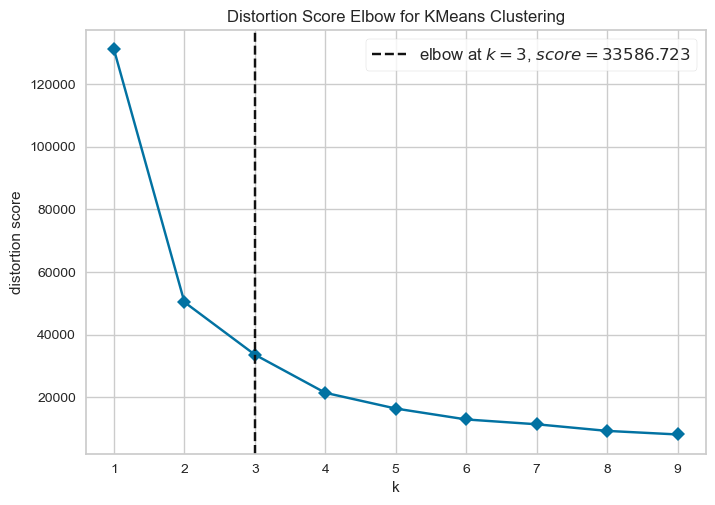

In [3]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

# Removing the 'Date' column as it's not relevant for clustering
data_clustering = wide_standardized_noNA.drop('Date', axis=1)

# Using the Elbow Method to find the optimal number of clusters
wcss = []  # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init = 'auto', random_state=123)
    kmeans.fit(data_clustering)
    wcss.append(kmeans.inertia_)

kmeans = KMeans(init='k-means++', n_init='auto', random_state=123)
visualizer = KElbowVisualizer(kmeans, k=(1,10), timings=False)
visualizer.fit(data_clustering)
visualizer.show()
plt.show()

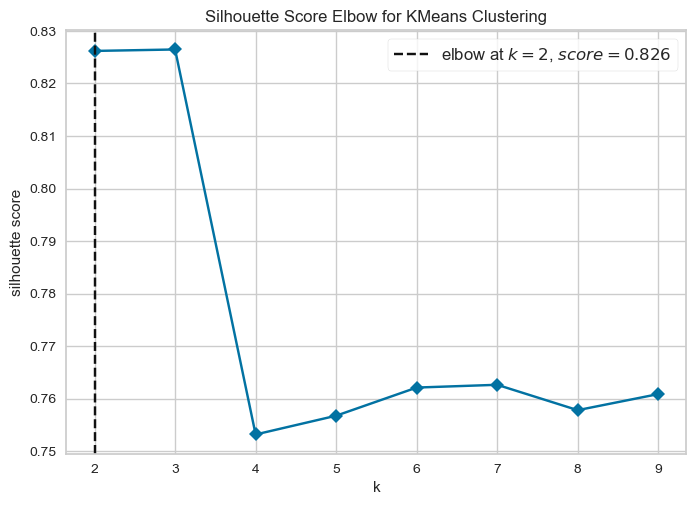

In [4]:
visualizer = KElbowVisualizer(kmeans, k=(2,10), metric='silhouette', timings=False)
visualizer.fit(data_clustering)
visualizer.show()
plt.show()

Cluster days together using DBSCAN

In [181]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from itertools import product
import numpy as np

# DBSCAN clustering
# We need to specify the epsilon (eps) and minimum samples (min_samples) parameters
# We will seek optimal ones by grid hyperparameter tuning

eps_values = np.arange(1,8,2) # eps values to be investigated
min_samples = np.arange(3,12,2) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data_clustering)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(data_clustering, DBS_clustering.labels_))

tmp = pd.DataFrame.from_records(DBSCAN_params, columns = ['Eps', 'Min. samples'])   
tmp['Silhouette score'] = sil_score

dbscan_tuning = tmp.pivot(index='Eps', columns='Min. samples', values='Silhouette score')
dbscan_tuning

Min. samples,3,5,7,9,11
Eps,,,,,
1,0.695260,0.696355,0.695738,0.770972,0.766900
3,0.831334,0.827545,0.827493,0.830291,0.829508
5,0.831077,0.830416,0.830416,0.830416,0.829673
7,0.833449,0.832668,0.832668,0.832668,0.900558


In [183]:
tmp['n of clusters'] = no_of_clusters

dbscan_nclusters = tmp.pivot(values='n of clusters', columns='Min. samples', index='Eps')
dbscan_nclusters

Min. samples,3,5,7,9,11
Eps,,,,,
1,8,6,5,4,4
3,7,5,5,4,3
5,6,4,4,4,3
7,5,3,3,3,2


Pairs plots

In [192]:
plotting_df = wide_standardized_noNA.copy()

plotting_df['Pot_Att'] = plotting_df[pot_variables].sum(axis=1)
plotting_df['Corr_N'] = plotting_df[trN_variables].sum(axis=1)
plotting_df['CosPhi'] = plotting_df[cosfi].sum(axis=1)
plotting_df.drop(pot_variables+trN_variables+cosfi, axis=1, inplace=True)

kmeans_k3 = KMeans(n_clusters=3, init='k-means++', n_init = 'auto', random_state=123)
plotting_df['K-Means Cluster'] = kmeans_k3.fit_predict(data_clustering)

In [ ]:
sns.pairplot(plotting_df, hue='K-Means Cluster', palette='Set1')
plt.suptitle('Pairs Plot of Selected Features with K-means Clustering', y=1.02)
plt.show()

In [212]:
dbscan_k3 = DBSCAN(eps=5, min_samples=11)
plotting_df['DBSCAN Cluster'] = dbscan_k3.fit_predict(data_clustering)

In [ ]:
sns.pairplot(plotting_df.drop('K-Means Cluster', axis=1), hue='DBSCAN Cluster', palette='Set2')
plt.suptitle('Pairs Plot of Selected Features with DBSCAN Clustering', y=1.02)
plt.show()

Perform Partial Component Analysis with 2 components so we can plot the clusters in 2D PCA space and print PCA loadings

In [202]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=123)
pca.fit(data_clustering)

# The factor loadings (how much each variable contributes to each factor)
pca_scores = pca.transform(data_clustering)
pca_loadings = pd.DataFrame(pca.components_, columns=data_clustering.columns)

pca_loadings

,PERD_GR,TR1_Corr_N,TR1_Pot_att,TR1_cosFi,TR2_Corr_N,TR2_Pot_att,TR2_cosFi,TR3_Corr_N,TR3_Pot_att,TR3_cosFi
0,0.008088,-0.144923,-0.191145,-0.005338,-0.395948,-0.389255,-0.398772,0.396239,0.398595,0.398963
1,-0.687674,-0.037752,-0.161906,-0.704673,-0.000351,0.005890,-0.009569,-0.031779,-0.029367,-0.030035


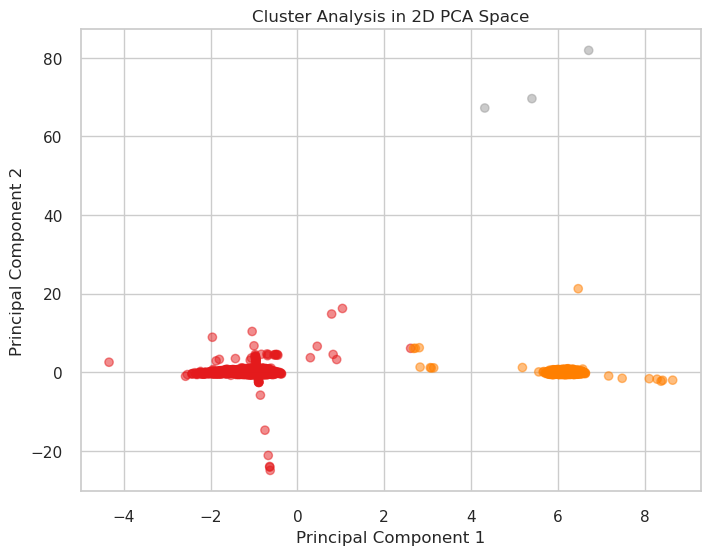

In [206]:
# Performing PCA with 2 components
pca_df = pca.fit_transform(data_clustering)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=plotting_df['K-Means Cluster'], alpha=0.5, cmap='Set1')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Analysis in 2D PCA Space')
plt.grid(True)
plt.show()

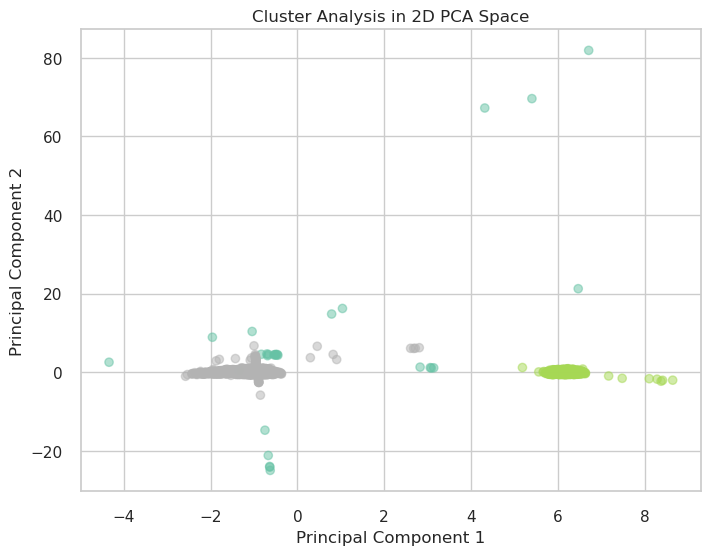

In [213]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=plotting_df['DBSCAN Cluster'], alpha=0.5, cmap='Set2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Analysis in 2D PCA Space')
plt.grid(True)
plt.show()

Plot dates on the x-axis and cluster groups on the y-axis

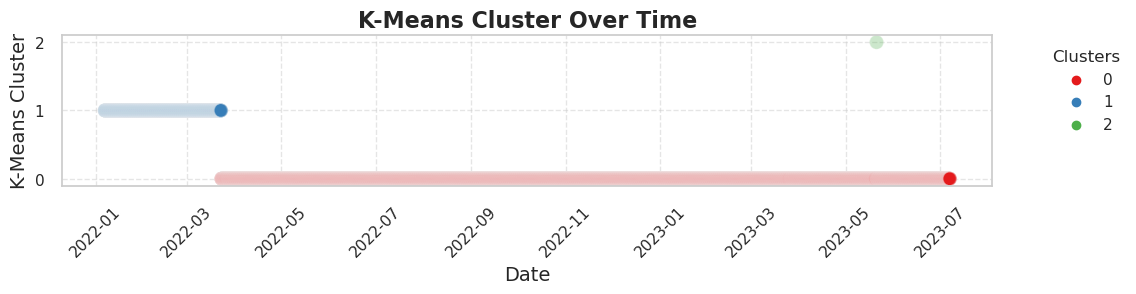

In [178]:
# Apply Seaborn's styling
sns.set(style="whitegrid")

plt.figure(figsize=(12, 1.95))

# Scatter plot with an aesthetically pleasing color palette
scatter = sns.scatterplot(data=plotting_df, x='Date', y='K-Means Cluster', 
                          hue='K-Means Cluster', palette='Set1', alpha=0.1, s=100)

# Enhance readability and aesthetics
plt.title('K-Means Cluster Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('K-Means Cluster', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Format the date axis for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())

# Adding a legend with a title and adjusting its position
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()

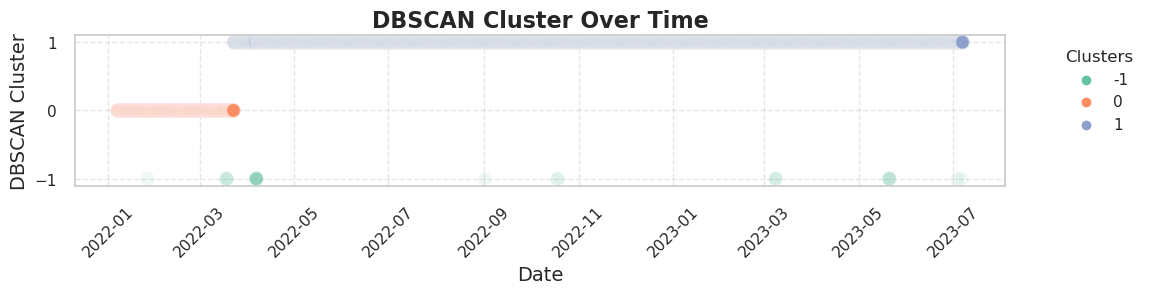

In [216]:
plt.figure(figsize=(12, 1.95))

# Scatter plot with an aesthetically pleasing color palette
scatter = sns.scatterplot(data=plotting_df, x='Date', y='DBSCAN Cluster', 
                          hue='DBSCAN Cluster', palette='Set2', alpha=0.1, s=100)

# Enhance readability and aesthetics
plt.title('DBSCAN Cluster Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('DBSCAN Cluster', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)

# Format the date axis for better readability
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())

# Adding a legend with a title and adjusting its position
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()